In [ ]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)

### 1. Initial data load and feature subset/tranform etc. 

In [4]:
data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))

In [5]:
dim(data)
names(data)

[1] 7291   19

[1] "id"                      "name"                   
 [3] "date"                    "manner_of_death"        
 [5] "armed"                   "age"                    
 [7] "gender"                  "race"                   
 [9] "city"                    "state"                  
[11] "signs_of_mental_illness" "threat_level"           
[13] "flee"                    "body_camera"            
[15] "longitude"               "latitude"               
[17] "is_geocoding_exact"      "smha_exp_per_capita"    
[19] "smi_prevalance"

#### Drop features as necessary

In [8]:
features_to_keep = c("date","armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness")
data = data[, (names(data) %in% features_to_keep)]

#### Convert features to desired datatypes

In [9]:
factor_cols = c("armed", "gender", "race", "state", "flee", "body_camera", "signs_of_mental_illness")
numeric_cols = c("age")

data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

#### Transform features as required

In [10]:
# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [17]:
# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

B    H    O    W 
1595 1089 1584 3023

In [19]:
# Fleeing -> convert NA to 'Missing'
data = data %>% 
  mutate(flee = case_when(
    flee == "Car" ~ "Car",
    flee == "Foot" ~ "Foot",
    flee == "Not fleeing" ~ "Not fleeing",
    flee == "Other" ~ "Other",
    TRUE ~ "Missing",
  )
)
data$flee = as.factor(data$flee)
summary(data$flee)

Car        Foot     Missing Not fleeing       Other 
       1183         943         666        4232         267

### 2. Dealing with missing values

Check missing data frequency for each column

In [21]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
date,0.0000000
armed,0.0000000
age,5.7742422
gender,0.1371554
race,0.0000000
state,0.0000000
signs_of_mental_illness,0.0000000
flee,0.0000000
body_camera,0.0000000


Check patterns in data missingness

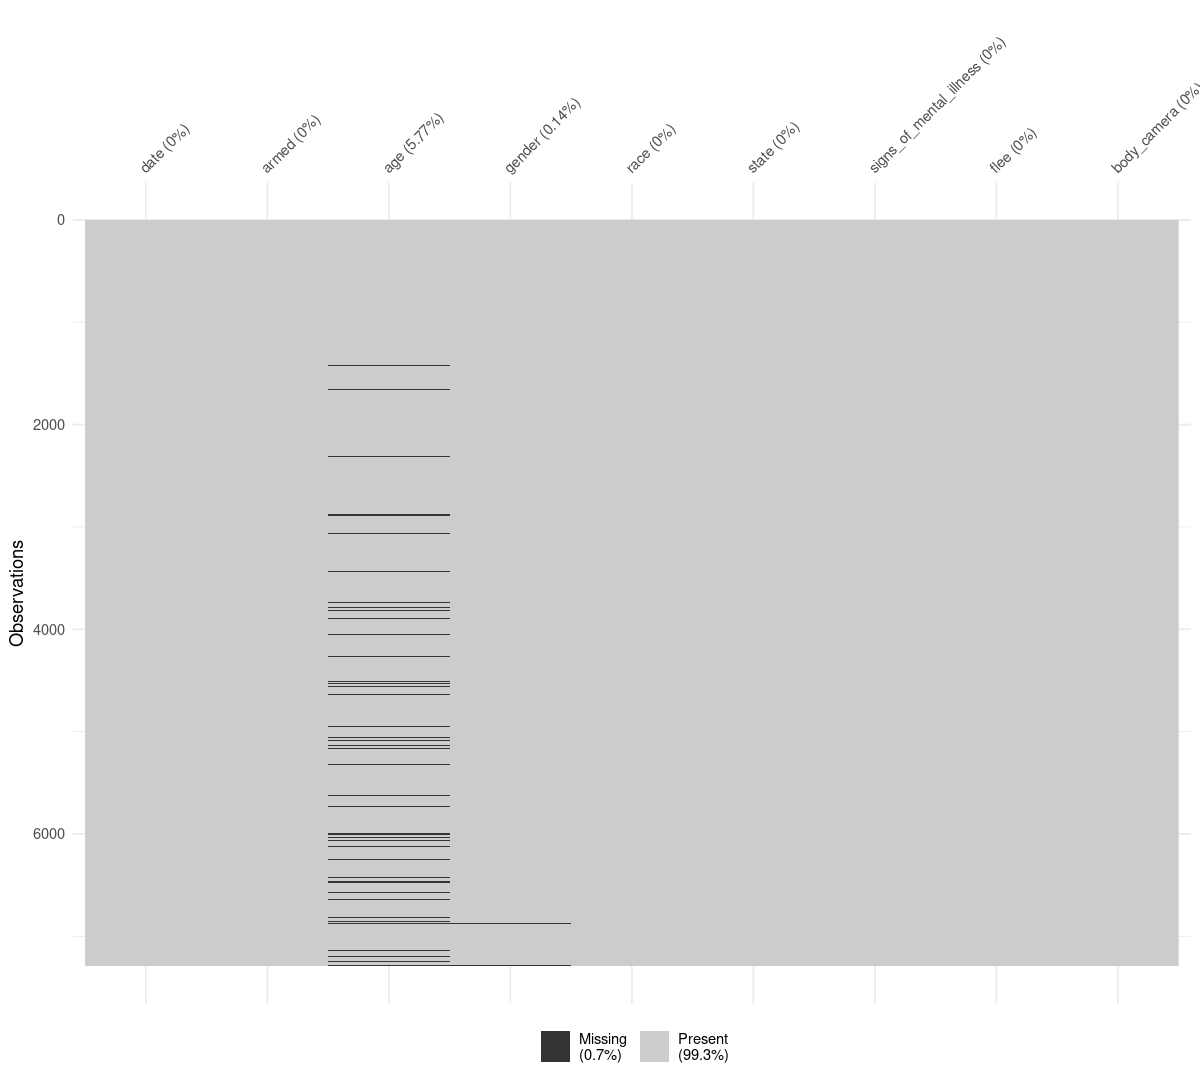

In [22]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

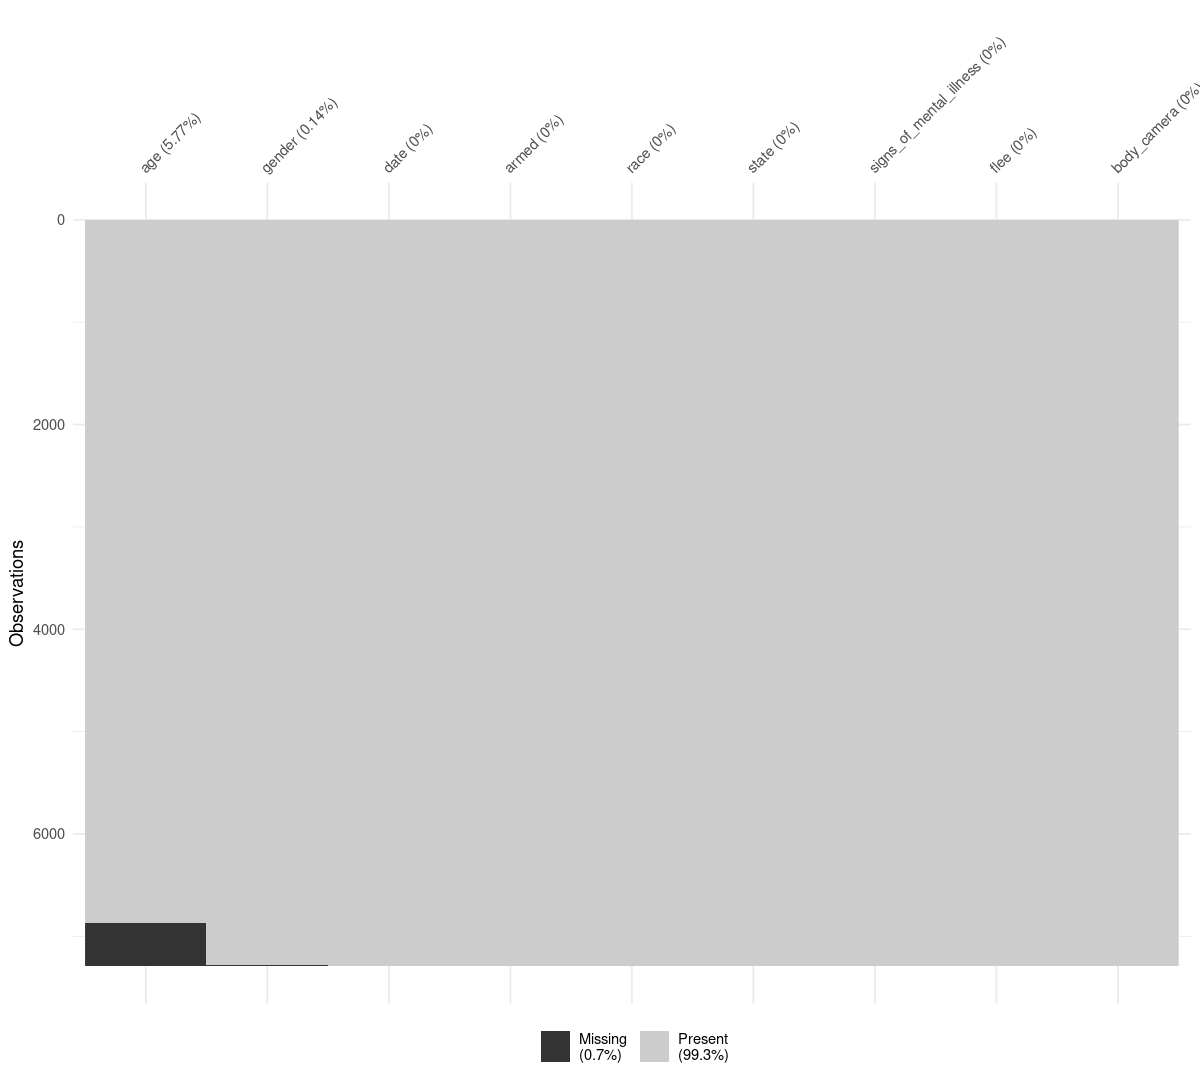

In [23]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

In [26]:
summary(data$gender)

F    M NA's 
 330 6951   10

In [35]:
# Drop where gender is NA? The observations are too few in number to add as a category
data = data %>% drop_na(gender)

In [33]:
# Age -> use mean/median imputation?
data$age[is.na(data$age)] <- median(data$age, na.rm = T)

> Missing values have been dealt with, but it would have been a good idea to check if the missingness pattern in age was MCAR/MAR/MNAR

### 3. Evaluation metric discussion

Since this is logistic regression and we are focused on interpretation, it may make sense to look at pure accuracy after using the model weightages as suggested by Alice, to handle the imbalanced nature of the target. 